In [4]:
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
import pytz
import os

In [5]:
import risk_model
import factorize
import account

In [6]:
availabe_accounts = pd.read_csv('account_ids.txt',header=None)
print (availabe_accounts.values)

[['DU1440139']
 ['U2909804']]


In [7]:
account_number = availabe_accounts.values[0][0]

In [8]:
rth = False

In [9]:
if account_number == availabe_accounts.values[1][0]:

    optimal_weights_regularized = pd.read_csv('data/optimal_weights_regularized_sa.csv',index_col = 'asset')
    close = pd.read_csv('data/close_sa.csv', index_col = 'date')
    
elif account_number == availabe_accounts.values[0][0]:
    
    optimal_weights_regularized = pd.read_csv('output/optimal_weights_regularized.csv',index_col = 'asset')
    close = pd.read_csv('data/close.csv', index_col = 'date')

## Portfolio Reading

In [10]:
portfolio = account.read_positions(subscribe = True, acctCode = account_number)

PositionEnd
Reading Portfolio


In [11]:
portfolio

,Position,marketPrice,marketValue,averageCost,unrealizedPNL,realizedPNL
Symbol,,,,,,
ADP,152.0,138.610001,21068.72,137.501603,168.48,0.0
ARE,-36.0,171.970001,-6190.92,176.217258,152.90,0.0
AVB,54.0,151.798004,8197.09,152.905487,-59.80,0.0
CAT,-43.0,142.750000,-6138.25,135.582951,-308.18,0.0
CERN,77.0,72.419998,5576.34,69.207749,247.34,0.0
CI,26.0,182.356995,4741.28,175.032473,190.44,0.0
ECL,75.0,196.268005,14720.10,192.193671,305.58,0.0
EQR,141.0,54.860001,7735.26,53.992503,122.32,0.0
EXC,-633.0,37.900002,-23990.70,38.557426,416.15,0.0


In [12]:
acc = account.read_account(reqId = 0, subscribe = True, acctCode = account_number)

AccountDownloadEnd. Account: DU1440139
Reading Account


In [13]:
all_weights, long, short, grv = risk_model.portfolio_calculation(portfolio)

In [14]:
long_value = long['marketValue'].sum()
short_value = short['marketValue'].sum()
#print ('Buying Power: {} $'.format(np.round(float(acc.loc['BuyingPower',:].values[0]), 4)))
print ('Gross Market Value: {} $'.format(np.round(grv, 4)))
print (' Long Value: {} $'.format(np.round(long_value,4)))
print (' Short Value: {} $'.format(np.round(short_value,4)))
print (' Net Liquidation: {} $'.format(np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)))
print (' Unrealize PNL: {} $'.format(np.round(portfolio['unrealizedPNL'].sum()),4))
print (' Loan Value: {} $'.format(np.round(float(acc.loc['GrossPositionValue'][0]) - float(acc.loc['EquityWithLoanValue'][0]), 4)))
print ('#####################################')
print ('Leverage Value: {}'.format(np.round(grv/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Long Leverage Value: {}'.format(np.round(long_value/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Short Leverage Value: {}'.format(np.round(np.abs(short_value)/float(acc.loc['EquityWithLoanValue'][0]), 4)))       

Gross Market Value: 231356.02 $
 Long Value: 140771.68 $
 Short Value: -90584.34 $
 Net Liquidation: 156862.0 $
 Unrealize PNL: 1348.0 $
 Loan Value: 74494.0 $
#####################################
Leverage Value: 1.4749
 Long Leverage Value: 0.8974
 Short Leverage Value: 0.5775


In [15]:
universe = portfolio.index
long_universe = long.index 
short_universe = short.index 

In [16]:
net_liq = np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)

## Projected portfolio balance

In [17]:
target_leverage = 1.5
grv_target = net_liq * target_leverage
excess_grv = grv_target - grv
print (excess_grv,'$')
marketVal_target = all_weights * grv_target

3936.9800000000396 $


In [18]:
balancing_order = marketVal_target['weights'] - portfolio['marketValue']
df_port = portfolio['marketPrice']
action_balance = pd.DataFrame(index = df_port.index, columns = ['shares'])
action_balance['shares'] = np.round(balancing_order / df_port,2)
to_drop = action_balance[action_balance['shares']==0.0].index
action_balance.drop(to_drop,axis=0,inplace=True)

In [19]:
grv_target

235293.0

In [20]:
val = account.read_nextvalidid(reqId=-1)

NextValidId: 1403
NextValidId: 1403


## Filtering stocks with significant market value

In [21]:
df_c = pd.DataFrame(data=close[optimal_weights_regularized.index].iloc[-1].values,
                   index = close[optimal_weights_regularized.index].iloc[-1].index,
                   columns = ['close'])
df_c.index.name = 'asset'

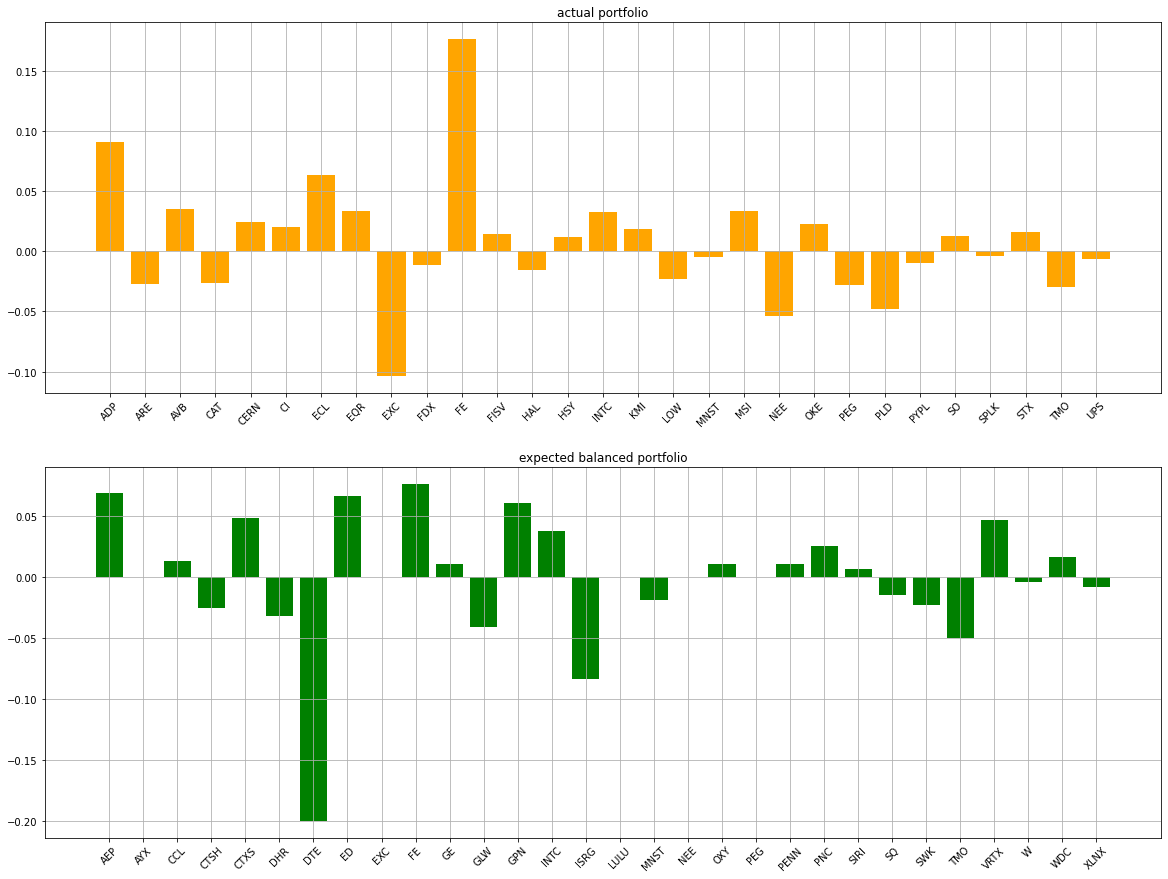

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))

x1 = all_weights.index
y1 = all_weights.values.flatten()
axs[0].grid(True)
axs[0].bar(x1, y1, width = 0.8, linewidth = 1, color='orange')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
axs[0].set_title('actual portfolio')

x2 = optimal_weights_regularized.index
y2 = optimal_weights_regularized.values.flatten()
axs[1].grid(True,)
axs[1].bar(x2, y2, width = 0.8, linewidth = 1, color='green')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(45)
axs[1].set_title('expected balanced portfolio')
plt.show()

## Processing data for execution

In [26]:
stock_to_balance = portfolio.index & optimal_weights_regularized.index
stock_to_close = portfolio.index ^ stock_to_balance

In [27]:
df_c_target = df_c.reindex(optimal_weights_regularized.index)
shares_target_float = (optimal_weights_regularized * grv_target)['optimal_weights']/df_c_target['close']

In [28]:
portfolio_shares_float = portfolio['marketValue'] / portfolio['marketPrice']

In [29]:
# Rebalance to optimal weights
action_final = pd.DataFrame(index = shares_target_float.index, columns = ['shares'])

for i in shares_target_float.index:
    
    if (i in stock_to_balance) and (i not in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - portfolio_shares_float[i]
        
    elif (i in stock_to_balance) and (i in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - (portfolio_shares_float[i] + action_balance['shares'][i])

    elif (i in action_balance.index) and (i not in stock_to_balance):
        action_final.loc[i,'shares'] = shares_target_float[i] + action_balance['shares'][i]
    else:
        action_final.loc[i,'shares'] = shares_target_float[i]

In [30]:
# rename columns
portfolio_shares_float = pd.DataFrame(portfolio_shares_float,columns = ['portfolio_shares'],index=portfolio_shares_float.index)
shares_target_float = pd.DataFrame(shares_target_float,columns = ['target_shares_not_balanced'],index=shares_target_float.index)

action_balance.columns = ['balance_lev_shares']
action_final.columns = ['final_action_shares']

In [31]:
# replacing too small actions value with nan value
treshold_long = 1
treshold_short = -1

action_final[(action_final['final_action_shares']>0) & (action_final['final_action_shares']< treshold_long)] = np.nan
action_final[(action_final['final_action_shares']<0) & (action_final['final_action_shares']> treshold_short)] = np.nan
action_final[action_final['final_action_shares']==0.0] = np.nan
action_final.dropna(axis=0,inplace=True)
action_final['final_action_shares'] = pd.to_numeric(action_final['final_action_shares'], errors='coerce')

In [32]:
action_conc = pd.concat([portfolio_shares_float,
                         action_balance,
                         shares_target_float,
                         action_final],axis=1)

In [33]:
isna_df = action_conc.isna()
for i in action_conc.index:
    if (isna_df.loc[i]['final_action_shares'] == True) & (isna_df.loc[i]['target_shares_not_balanced'] == False) :
        action_conc.drop(i, inplace = True)

In [34]:
action_conc.round(2)

,portfolio_shares,balance_lev_shares,target_shares_not_balanced,final_action_shares
ADP,152.0,2.64,NaN,NaN
AEP,NaN,NaN,195.36,195.36
ARE,-36.0,-0.67,NaN,NaN
AVB,54.0,0.87,NaN,NaN
CAT,-43.0,-0.68,NaN,NaN
CCL,NaN,NaN,198.91,198.91
CERN,77.0,1.30,NaN,NaN
CI,26.0,0.45,NaN,NaN
CTSH,NaN,NaN,-89.28,-89.28
CTXS,NaN,NaN,84.27,84.27


## Executing on TWS

In [32]:
op = account.cancel_openorders()

open order ended


In [33]:
# closing positions not in shares target
if not stock_to_close.empty:
    next_order_id = account.closing_positions(stock_to_close = stock_to_close,
                                              portfolio = portfolio , 
                                              order_id = val,
                                              ordersPriority = 'Patient')
else:
    print ('There is no stock to close...')
    next_order_id = val

app is running ...
closing 17 positions which are not present in action
closing position for ACLS is: 32 
closing position for ALL is: 40 
closing position for CLF is: 424 
closing position for CWT is: 50 
closing position for DRQ is: 44 
closing position for ETR is: 9 
closing position for GTN is: 86 
closing position for MAC is: 49 
closing position for MCY is: 53 
closing position for NXST is: 19 
closing position for TWTR is: 34 
closing position for UAA is: 112 
closing position for UCTT is: 51 
closing position for UFPI is: 53 
closing position for VGR is: 330 
closing position for VNO is: 18 
closing position for WELL is: 43 


In [34]:
action_final = action_final.astype('int')
account.placing_final_orders(action_final=action_final, 
                             order_id = next_order_id,
                             ordersPriority = 'Patient')

buy order quantity placed for OHI is: 35 
buy order quantity placed for LSI is: 6 
sell order quantity placed for WLK is: 9 
sell order quantity placed for TCBI is: 73 
sell order quantity placed for BOKF is: 29 
sell order quantity placed for CATY is: 38 
sell order quantity placed for ZION is: 30 
sell order quantity placed for CFR is: 15 
buy order quantity placed for MRO is: 44 
buy order quantity placed for OAS is: 23 
sell order quantity placed for PTEN is: 455 
buy order quantity placed for FLO is: 8 
buy order quantity placed for KR is: 40 
buy order quantity placed for QCOM is: 14 
buy order quantity placed for KLAC is: 13 
buy order quantity placed for TER is: 4 
sell order quantity placed for BB is: 153 
sell order quantity placed for ALTR is: 19 
buy order quantity placed for CCMP is: 1 
buy order quantity placed for ATVI is: 4 
buy order quantity placed for IBM is: 9 
buy order quantity placed for QRVO is: 8 
buy order quantity placed for MSFT is: 1 
sell order quantity pl

In [37]:
if rth:
    print ('we are in regular trading hours...')
    open_orders_all = account.get_openorders()
    if list(open_orders_all.values) == []:
        portfolio = account.read_positions(subscribe = True, acctCode = account_number)
        not_executed = portfolio.index ^ action_final.index
        if list(not_executed)==[]:
            print ('all orders are executed')
        else:
            print ('some orders still not executed')
            print (not_executed)
    
else:
    print ('we are not in regular trading hours...')
    open_orders_all = account.get_openorders()    
    not_executed = open_orders_all.index ^ action_conc.index
    
    if list(not_executed)==[]:
        print ('all orders are ready to be executed...')
    
    else:
        print (list(not_executed))
        print ('some orders are not placed. please check manually or retry to run the functions...')
    
    table = pd.concat([action_conc, open_orders_all[['open orders']]],axis=1)

we are not in regular trading hours...
open order ended
open order ended
all orders are ready to be executed


In [38]:
table

,portfolio_shares,balance_lev_shares,target_shares_not_balanced,final_action_shares,open orders
ACLS,31.999999,-0.73,NaN,NaN,32
ALL,39.999999,-0.88,NaN,NaN,40
ALTR,NaN,NaN,-19.135202,-19.135202,19
AMD,18.000000,-0.41,6.589530,-11.000470,11
ATVI,NaN,NaN,4.650076,4.650076,4
BB,NaN,NaN,-153.278937,-153.278937,153
BOKF,NaN,NaN,-29.925890,-29.925890,29
CATY,NaN,NaN,-38.487246,-38.487246,38
CCMP,NaN,NaN,1.489251,1.489251,1
CFR,NaN,NaN,-15.922872,-15.922872,15


## Commission report of last realized trades

In [35]:
com = account.commission_report(acctCode = account_number, time= '')

In [36]:
com

,ticker,shares,action,price,marketValue,RealizedPNL,commission
time,,,,,,,


In [43]:
execution_date = com.index[-1]

In [44]:
RealizedPNL = np.round(pd.to_numeric(com.loc[slice(execution_date)]['RealizedPNL'], errors='coerce').sum(),2)
#Total_Realized_Return = np.round((RealizedPNL/net_liq)*100,2)
print ('Report for {}:'.format(execution_date.date()))
print (' Market Value: {} $'.format(np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)))
print (' Total Commission: {} $'.format(np.round(com.loc[slice(execution_date)]['commission'].sum(),2)))
print (' Total Realized PNL: {} $'.format(RealizedPNL))  
#print (' Total Realized Return: {} %'.format(Total_Realized_Return))  


Report for 2020-08-10:
 Market Value: 61368.17 $
 Total Commission: 52.09 $
 Total Realized PNL: 611.92 $


In [48]:
rootdir = 'data'
if account_number == availabe_accounts.values[0][0]:
    for subdir, dirs, files in os.walk(rootdir):
        for item in files:

            if item.endswith('.csv') and item.split('_')[0] == 'commission' and item.split('_')[1] == 'report':
                report = pd.read_csv(item, index_col= 'date')
                report.loc[execution_date.date(),'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
                report.loc[execution_date.date(),'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
                report.loc[execution_date.date(),'total realized pnl'] = RealizedPNL

            else:
                report = pd.DataFrame(columns = ['market value','total commission','total realized pnl'], 
                              index = [execution_date.date()])
                report.index.name = 'date'
                report.loc[:,'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
                report.loc[:,'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
                report.loc[:,'total realized pnl'] = RealizedPNL
    report.to_csv('data/commission_report.csv')
    com_rep = pd.read_csv('data/commission_report.csv', index_col= 'date')
    
elif account_number == availabe_accounts.values[1][0]:
    for subdir, dirs, files in os.walk(rootdir):
        for item in files:

            if item.endswith('.csv') and item.split('_')[0] == 'commission' and item.split('_')[1] == 'reportSA' :
                report = pd.read_csv(item, index_col= 'date')
                report.loc[execution_date.date(),'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
                report.loc[execution_date.date(),'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
                report.loc[execution_date.date(),'total realized pnl'] = RealizedPNL

            else:
                report = pd.DataFrame(columns = ['market value','total commission','total realized pnl'], 
                              index = [execution_date.date()])
                report.index.name = 'date'
                report.loc[:,'market value'] = np.round(com.loc[slice(execution_date)]['marketValue'].sum(),2)
                report.loc[:,'total commission'] = np.round(com.loc[slice(execution_date)]['commission'].sum(),2)
                report.loc[:,'total realized pnl'] = RealizedPNL
    report.to_csv('data/commission_reportSA.csv')
    com_rep = pd.read_csv('data/commission_reportSA.csv', index_col= 'date')
    

In [49]:
com_rep 

,market value,total commission,total realized pnl
date,,,
2020-08-10,61368.17,52.09,611.92


In [50]:
next_rebalance_date = execution_date.date() + datetime.timedelta(days = 14)

In [51]:
print ('The next rebalance date for {} is set to: {}'.format(account_number,next_rebalance_date))

The next rebalance date for U2909804 is set to: 2020-08-24
